In [5]:
%reset

In [6]:
import sys
from pathlib import Path

# Current working dir  …/DGRB Scripts/Test - sbi for 1 SFG and 1 mAGN…
# parent[0] → …/DGRB Scripts
# parent[1] → …/home/users/ids29           ← where “DGRB/” lives
package_path = Path.cwd().parents[1] / "DGRB"   # /home/users/ids29/DGRB

sys.path.insert(0, str(package_path))           # make it import-able


In [7]:
import aegis
import numpy as np
import healpy as hp
import torch
import pickle as pk
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from os import listdir
import os
import sys
from sbi import utils as utils
from sbi import analysis as analysis
# from sbi.inference.base import infer
from getdist import plots, MCSamples
import pickle
from scipy.stats import norm
from scipy.integrate import quad, simpson
from joblib import Parallel, delayed

%matplotlib inline

SFG #1 & SFG #2

In [8]:
with open('training_photon_info_list_2SFGs.pkl', 'rb') as f:
    photon_info_list = pickle.load(f)

theta_train = torch.load('thetas_2SFGs.pt')

with open('test_photon_info_2SFGs.pkl', 'rb') as f:
    test_photon_info = pickle.load(f)

theta_test = torch.load('input_params_2SFGs.pt')

# Define the prior using sbi.utils.BoxUniform
parameter_range = torch.load('parameter_range_2SFGs.pt')

# prior = utils.BoxUniform(low=parameter_range[0], high=parameter_range[1])

/tmp/ipykernel_3018695/1329175299.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  theta_train = torch.load('thetas_2SFGs.pt')
/tmp/ipykernel_3018695/1329175299.py:9: Fut

In [9]:
parameter_range_aegis = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range = [1000, 100000] #MeV
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*18]
max_radius = 8.5 + 20*2 #kpc
exposure = 2000*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
angular_cut = np.pi #10*u.deg.to('rad') #degrees
angular_cut_gen = np.pi #angular_cut*1.5
lat_cut = 0 #2*u.deg.to('rad') #degrees
lat_cut_gen = lat_cut*0.5

In [10]:
my_cosmology = 'Planck18'
z_range = [0, 14]
luminosity_range = 10.0**np.array([37, 50]) # Minimum value set by considering Andromeda distance using Fermi as benchmark and receiving 0.1 photon at detector side
my_AEGIS = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range_aegis, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, energy_range_gen=energy_range_gen, cosmology = my_cosmology, z_range = z_range, verbose = False)
my_AEGIS.angular_cut_gen, my_AEGIS.lat_cut_gen = angular_cut_gen, lat_cut_gen

In [11]:
def compute_moments(energies):
    """Compute the mean and variance of the energies."""
    mean_E = np.mean(energies)
    var_E = np.var(energies)
    return mean_E, var_E

def compute_quantiles(energies, quantiles=[10, 25, 50, 75, 90]):
    """
    Compute the specified quantiles (in percent).
    For example, the 25th quantile is the energy such that 25% of the data lies below it.
    Returns a dictionary mapping percentiles to values.
    """
    q_values = np.percentile(energies, quantiles)
    return dict(zip(quantiles, q_values))

def normalize_quantiles(q_dict, E_min, E_max):
    """
    Normalize quantile values from a dictionary using min-max normalization.
    """
    norm_q = {perc: (val - E_min) / (E_max - E_min) for perc, val in q_dict.items()}
    return norm_q




def effective_spectral_index(energies, E_lower):
    """
    Compute effective spectral index via MLE.
    Returns np.nan if there are no photons.
    """
    energies = np.array(energies)
    n = len(energies)
    if n == 0:
        return np.nan
    sum_logs = np.sum(np.log(energies / E_lower))
    return 1 + n / sum_logs

def smooth_binned_gamma(binned_gamma, counts, global_gamma, min_count=6):
    """
    Smooth binned effective spectral indices if the count in a bin is low.
    
    Parameters:
      binned_gamma : array-like
          Array of spectral indices per energy bin (may contain np.nan for empty bins).
      counts : array-like
          Array of photon counts per bin.
      global_gamma : float
          Global effective spectral index, used as fallback.
      min_count : int
          Minimum photon count required to trust a bin.
    
    Returns:
      smoothed_gamma : numpy array with smoothed spectral index values.
    """
    binned_gamma = np.array(binned_gamma)
    counts = np.array(counts)
    num_bins = len(binned_gamma)
    smoothed_gamma = binned_gamma.copy()

    # Loop over each bin.
    for i in range(num_bins):
        if counts[i] < min_count or np.isnan(binned_gamma[i]):
            indices = [i]
            if i > 0:
                indices.append(i-1)
            if i < num_bins - 1:
                indices.append(i+1)
            indices = list(set(indices))  # ensure uniqueness
            
            # Only include indices with non-NaN values
            valid_indices = [j for j in indices if not np.isnan(binned_gamma[j])]
            if valid_indices:
                # Use the counts as weights. If any count is zero, it's fine; it will reduce the weight.
                weights = np.array([counts[j] for j in valid_indices], dtype=np.float32)
                # If all weights sum to 0, default to global_gamma.
                if np.sum(weights) > 0:
                    smoothed_gamma[i] = np.average(binned_gamma[valid_indices], weights=weights)
                else:
                    smoothed_gamma[i] = global_gamma
            else:
                # If none of the neighboring bins have a valid estimate, fallback to global_gamma.
                smoothed_gamma[i] = global_gamma
    return smoothed_gamma

def compute_binned_effective_spectral_indices(energies, num_bins, energy_range):
    """
    Divide the energy range into logarithmic bins and compute the effective spectral index in each bin.
    For bins with few photons (count < min_count) or empty bins, apply smoothing by averaging with neighboring bins.
    
    Returns:
      smoothed_gamma : 1D array containing the (possibly smoothed) spectral index for each bin.
      global_gamma  : Effective spectral index computed using all energies (with the lowest bin edge as E_lower).
      counts        : Raw photon counts per bin.
    """
    bins = np.geomspace(energy_range[0], energy_range[1], num_bins + 1)
    binned_gamma = []
    counts = []  # photon counts per bin

    # Loop over bins
    for i in range(len(bins) - 1):
        mask = (energies >= bins[i]) & (energies < bins[i+1])
        energies_bin = energies[mask]
        counts.append(len(energies_bin))
        # Compute gamma for the bin; if the bin is empty, effective_spectral_index returns np.nan.
        gamma = effective_spectral_index(energies_bin, E_lower=bins[i])
        binned_gamma.append(gamma)
    
    binned_gamma = np.array(binned_gamma)
    counts = np.array(counts)
    
    # Compute the global effective spectral index over all energies using the first bin's lower edge.
    global_gamma = effective_spectral_index(energies, E_lower=bins[0])
    
    # Smooth the binned_gamma using neighboring bins if counts in a bin are low.
    smoothed_gamma = smooth_binned_gamma(binned_gamma, counts, global_gamma, min_count=6)
    
    return smoothed_gamma, global_gamma, counts




def normalize_binned_gamma(binned_gamma, global_gamma, mode='ratio'):
    """
    Normalize the binned effective spectral indices relative to the global effective spectral index.
    
    Parameters:
      binned_gamma : np.array
          Array of effective spectral indices for each energy bin.
      global_gamma : float
          The global effective spectral index computed over the entire energy range.
      mode : str, optional
          'ratio' for normalized_binned_gamma = binned_gamma / global_gamma,
          'difference' for normalized_binned_gamma = (binned_gamma - global_gamma)/global_gamma.
          Default is 'ratio'.
    
    Returns:
      normalized_binned_gamma : np.array
    """
    if mode == 'ratio':
        # Return ratio relative to global spectral index
        normalized_binned_gamma = binned_gamma / global_gamma
    elif mode == 'difference':
        # Return relative differences with baseline 0
        normalized_binned_gamma = (binned_gamma - global_gamma) / global_gamma
    else:
        raise ValueError("Unknown mode for normalization. Choose 'ratio' or 'difference'.")
    return normalized_binned_gamma


# --- concise, log-binned 1-D energy histogram ---------------------------
def compute_energy_only_histogram(energies, num_bins, energy_range=(1000, 100_000)):
    """
    Log-bin photon energies (MeV) into `num_bins` and return raw counts.

    Parameters
    ----------
    energies      : 1-D iterable (list / np.ndarray / torch.Tensor)
    num_bins      : int, number of logarithmic bins
    energy_range  : (low, high) edges in MeV  (default 1–100 GeV)

    Returns
    -------
    hist : 1-D np.ndarray length `num_bins`  (integer counts)
    """
    edges = np.geomspace(energy_range[0], energy_range[1], num_bins + 1, dtype=np.float32)
    hist, _ = np.histogram(np.asarray(energies, dtype=np.float32), bins=edges)
    return hist.astype(np.float32)


def normalize_energy_only_hist(energy_only_hist):
    """
    Normalize a 1D histogram so it sums to 1.
    """
    total = np.sum(energy_only_hist) # this is the total number of photons in the energy-only histogram
    if total == 0:
        return energy_only_hist  # or handle the zero-case as needed
    return energy_only_hist / total

def compute_summary_statistics(energies, N_Ebins):
    """
    Given an array of photon energies (all between 1 and 100 GeV), compute a set of summary statistics:
      1. Mean energy.
      2. Variance of energy.
      3. Quantiles: 10%, 25%, 50%, 75%, and 90%.
      4. Effective spectral index estimated from the data.
      
    Returns the statistics in a dictionary and also a flattened torch tensor.
    """
    # 1. Mean and variance
    mean_E, var_E = compute_moments(energies)
    
    # 2. Quantiles
    quant_dict = compute_quantiles(energies)  # This returns a dict like {10: val, 25: val, ...}
    norm_quant_dict = normalize_quantiles(quant_dict, E_min=energy_range[0], E_max=energy_range[1])

    energy_only_hist = compute_energy_only_histogram(energies, num_bins=N_Ebins, energy_range=energy_range)

    binned_gamma, global_gamma, energy_only_hist = compute_binned_effective_spectral_indices(energies, num_bins=N_Ebins, energy_range=energy_range)
    norm_binned_gamma = normalize_binned_gamma(binned_gamma, global_gamma, mode='ratio')
    norm_energy_only_hist = normalize_energy_only_hist(energy_only_hist)
    
    # If you want to pass the summary statistic to sbi, it is best to use a fixed-size vector (e.g., a torch tensor).
    # For example, arrange the stats in a consistent order:
    scalars  = np.array([
        energies.size, # total number of photons
        mean_E,
        var_E,
        global_gamma
    ], dtype=np.float32)

    
    return scalars , norm_quant_dict, norm_binned_gamma, norm_energy_only_hist

def normalize_energy_dependent_hist(energy_dependent_hist, total_pixels):
    """
    Normalize a 2D histogram so that each column sums to 1.
    total_pixels: the fixed number of pixels (for example, len(roi_pix_i))
    """
    # If the histogram is of shape (N_countbins, N_Ebins),
    # each column should ideally sum to total_pixels.
    normalized_hist = energy_dependent_hist / total_pixels
    return normalized_hist

In [12]:
# a simple simulator with the total number of photons as the summary statistic
def simulator(photon_info):

    N_side = 2**6
    #parameters for the summary statistic
    
    center_mask = 10 #deg 
    lat_mask = 5 #deg 
    N_Ebins = 20
    # Ebinspace = 'log'#'linear'
    N_countbins = 10
    countbinspace = 'custom'#'linear'
    mincount_2D_hist, maxcount_2D_hist = 0, 38 # For energy-dependent 2D histogram # Change for different data sets. Consider the data set with the maximum number of photons to decide the value of 'maxcount'.
    mincount_1D_counts_hist, maxcount_1D_counts_hist = 0, 123 # For counts only 1D histogram # Change for different data sets. Consider the data set with the maximum number of photons to decide the value of 'maxcount'.
    N_pix = 12*N_side**2
    pix_i = np.linspace(0, N_pix-1, N_pix, dtype = 'int')
    roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')))[0]

    # Get energy dependent 2D histogram
    roi_map = my_AEGIS.get_roi_map_summary(photon_info = photon_info, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = 'log', roi_pix_i = roi_pix_i)
    # print(f"For energy-dependent hist, max counts = {np.max(roi_map)}; roi_map.shape = {roi_map.shape}")
    energy_dependent_hist = my_AEGIS.get_counts_histogram_from_roi_map(roi_map, mincount = mincount_2D_hist, maxcount = maxcount_2D_hist, N_countbins = N_countbins, countbinspace = countbinspace)
    total_pixels = roi_pix_i.size
    norm_energy_dependent_hist = normalize_energy_dependent_hist(energy_dependent_hist, total_pixels)

    # Get counts-only 1D histogram
    roi_map = my_AEGIS.get_roi_map_summary(photon_info = photon_info, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = 'single', roi_pix_i = roi_pix_i) # 'single' means only one energy bin.
    # print(f"For counts-only hist, max counts = {np.max(roi_map)}; roi_map.shape = {roi_map.shape}")
    counts_only_hist = my_AEGIS.get_counts_histogram_from_roi_map(roi_map, mincount = mincount_1D_counts_hist, maxcount = maxcount_1D_counts_hist, N_countbins = N_countbins, countbinspace = countbinspace)
    total_pixels = roi_pix_i.size
    norm_counts_only_hist = normalize_energy_dependent_hist(counts_only_hist, total_pixels)


    photon_pixels = hp.ang2pix(N_side, photon_info['angles'][:, 0], photon_info['angles'][:, 1])
    roi_mask = np.isin(photon_pixels, roi_pix_i)
    energies_in_roi = photon_info['energies'][roi_mask]


    unnorm_scalars, norm_quant_dict, norm_binned_gamma, norm_energy_only_hist = compute_summary_statistics(energies_in_roi, N_Ebins = N_Ebins) # Original code
    # unnorm_scalars = compute_summary_statistics(energies_in_roi, N_Ebins = N_Ebins) # DELETE
    
    return unnorm_scalars, norm_quant_dict, norm_binned_gamma, norm_energy_only_hist, norm_counts_only_hist, norm_energy_dependent_hist
    # return unnorm_scalars, norm_counts_only_hist, norm_energy_dependent_hist # DELETE

In [13]:
# --- Helper function to process a single simulation ---
def process_simulation(photon_info):
    """
    Process one simulation's photon_info and return a dictionary with sub-statistics.
    It calls your modified simulator() function.
    """
    # Call your simulator that returns sub-statistics:
    # unnorm_scalars: 1D numpy array (global scalar features, NOT normalized)
    # norm_quant_dict: dict of normalized quantiles (keys, e.g., 10,25,50,75,90)
    # norm_binned_gamma: normalized 1D array, one element per energy bin
    # norm_energy_only_hist: normalized 1D energy-only histogram
    # norm_energy_dependent_hist: normalized 2D array (we will flatten it)
    unnorm_scalars, norm_quant_dict, norm_binned_gamma, norm_energy_only_hist, norm_counts_only_hist, norm_energy_dependent_hist = simulator(photon_info) # Original code
    # unnorm_scalars, norm_counts_only_hist, norm_energy_dependent_hist = simulator(photon_info) # DELETE
    
    # Convert the normalized quantiles dictionary into a vector.
    # We sort the keys so that the order is fixed.
    QUANTILES = [10, 25, 50, 75, 90]  
    sorted_keys = sorted(norm_quant_dict.keys())
    assert sorted_keys == QUANTILES, "Quantile keys differ from expected set"
    norm_quant_vector = np.array([norm_quant_dict[k] for k in sorted_keys], dtype=np.float32)
    
    # Flatten the 2D energy-dependent histogram and counts-only histogram.
    flat_energy_dependent_hist = np.asarray(norm_energy_dependent_hist, dtype=np.float32).flatten()
    flat_counts_only_hist = np.asarray(norm_counts_only_hist, dtype=np.float32).flatten()
    
    # Package the sub-statistics into a dictionary.
    return {
        "scalars": unnorm_scalars,                  # 1D array (e.g., shape (D_scalar,))
        "norm_quant": norm_quant_vector,            # 1D array (e.g., 5 elements)
        "binned_gamma": norm_binned_gamma,          # 1D array (num_energy_bins,)
        "energy_only_hist": norm_energy_only_hist,   # 1D array (num_energy_bins,)
        "counts_only_hist": flat_counts_only_hist,  # 1D flattened array
        "energy_dependent_hist": flat_energy_dependent_hist  # 1D flattened array
    }

# --- Run the processing in parallel over all simulations ---
num_workers = -1  # or your chosen parallel worker count
results = Parallel(n_jobs=num_workers)(
    delayed(process_simulation)(photon_info) for photon_info in photon_info_list
)

# --- Extract the unnormalized global scalars from all simulations ---
scalars_list = [res["scalars"] for res in results]  # List of arrays, one per simulation

# Stack them to form a 2D array: shape (num_simulations, D_scalar)
scalars_all = np.stack(scalars_list, axis=0)

# Compute per-element mean and std over the training simulations
scalars_mean = np.mean(scalars_all, axis=0)
scalars_std = np.std(scalars_all, axis=0)
if (scalars_std == 0).sum() > 0:
    print(f"Warning: Some standard deviations are zero. Adjusting to avoid division by zero. Number of zero stds: {(scalars_std == 0).sum()}")
# Prevent division by zero
scalars_std[scalars_std == 0] = 1.0

# --- Apply z-normalization to the global scalars for each simulation ---
normalized_scalars_list = [(s - scalars_mean) / scalars_std for s in scalars_list]

# --- Now, build the final overall summary vector for each simulation ---
# The design here is to concatenate, for each simulation:
# [normalized_scalars, norm_quant_vector, binned_gamma, energy_only_hist, flattened energy_dependent_hist]
final_summary_list = []
for i, res in enumerate(results):
    final_vector = np.concatenate([
        normalized_scalars_list[i],     # Normalized global scalars
        res["norm_quant"],              # Normalized quantiles (fixed order)
        res["binned_gamma"],            # Normalized binned spectral indices (1D)
        res["energy_only_hist"],        # Normalized energy-only histogram (1D)
        res["counts_only_hist"],        # Flattened normalized 1D counts-only histogram
        res["energy_dependent_hist"]    # Flattened normalized 2D energy-dependent histogram
    ])
    final_summary_list.append(final_vector.astype(np.float32))

# Stack all simulation summaries into a 2D array
final_summary_array = np.stack(final_summary_list, axis=0)  # Shape: (num_simulations, final_vector_dim)

# Convert the overall summary statistics to a torch tensor for sbi usage
summary_tensor_train = torch.tensor(final_summary_array, dtype=torch.float32)

Observation - actual data

In [16]:
# Call your simulator function on obs_photon_info to get the sub-statistics.
unnorm_scalars_obs, norm_quant_dict_obs, norm_binned_gamma_obs, norm_energy_only_hist_obs, norm_counts_only_hist_obs, norm_energy_dependent_hist_obs = simulator(test_photon_info) # Original code
# unnorm_scalars_obs, norm_counts_only_hist_obs, norm_energy_dependent_hist_obs = simulator(test_photon_info_1) # CHANGE 'test_photon_info' if needed # DELETE
# 1. Normalize the global scalar features using the training set parameters.
#    It is assumed that unnorm_scalars_obs is a 1D NumPy array.
norm_scalars_obs = (unnorm_scalars_obs - scalars_mean) / scalars_std

# 2. Process the quantiles dictionary.
#    Sorting keys ensures a consistent ordering (e.g., [10, 25, 50, 75, 90]).\
QUANTILES = [10, 25, 50, 75, 90] 
sorted_keys = sorted(norm_quant_dict_obs.keys())
assert sorted_keys == QUANTILES, "Quantile keys differ from expected set"
norm_quant_vector_obs = np.array([norm_quant_dict_obs[k] for k in sorted_keys], dtype=np.float32)

# 3. Flatten the normalized 2D energy-dependent histogram and 1D counts-only histogram.
flat_energy_dependent_hist_obs = np.asarray(norm_energy_dependent_hist_obs, dtype=np.float32).flatten()
flat_counts_only_hist_obs = np.asarray(norm_counts_only_hist_obs, dtype=np.float32).flatten()


# 4. Now, form the overall summary statistic in a fixed, consistent order.
# For example, we concatenate in the following order:
# [z-normalized scalars, normalized quantiles vector, normalized binned gamma, normalized energy-only histogram, flattened energy-dependent histogram]
overall_summary_vector_obs = np.concatenate([
    norm_scalars_obs,           # Global scalar features (z-normalized)
    norm_quant_vector_obs,      # Normalized quantiles as a fixed-order vector
    norm_binned_gamma_obs,      # Normalized effective spectral indices per energy bin
    norm_energy_only_hist_obs,  # Normalized energy-only histogram (1D)
    flat_counts_only_hist_obs,  # Flattened normalized 1D counts-only histogram
    flat_energy_dependent_hist_obs  # Flattened normalized 2D energy-dependent histogram
])

# 5. Convert the overall summary vector into a torch tensor.
summary_tensor_test = torch.tensor(overall_summary_vector_obs, dtype=torch.float32)


CHATGPT's training iterations

summary dims: 259  →  83 kept
 Neural network successfully converged after 108 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 108
        Best validation performance: -1.1084
        -------------------------
        


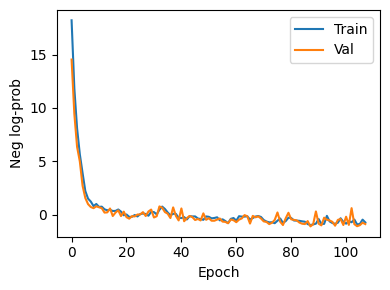

/home/users/ids29/sbi/sbi/inference/posteriors/mcmc_posterior.py:118: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

/tmp/ipykernel_3018695/1514966954.py:170: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  markers=np.array(theta_test).flatten(),


Removed no burn in


<Figure size 640x480 with 0 Axes>

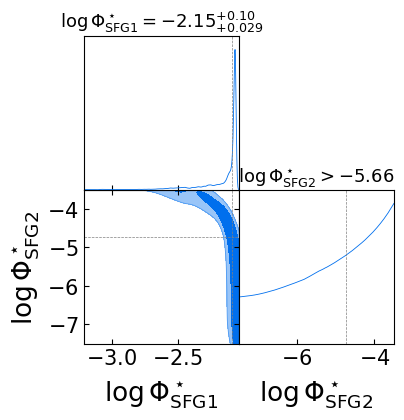

In [19]:
#!/usr/bin/env python3
"""
End-to-end NSF + SNPE_C_Custom with automatic summary-dimension pruning

• keeps θ in physical units
• drops:
      – columns with std < 1e-8           (blank cells in heat-map)
      – columns whose |Spearman ρ| ≤ 0.10 with every parameter
"""

%matplotlib inline
from __future__ import annotations
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from torch.optim import AdamW
from sbi.utils import BoxUniform
from sbi.neural_nets import posterior_nn
from sbi.inference import SNPE
from getdist import MCSamples, plots

# ----------------------------------------------------------------------
# helper: remove zero-var + low-ρ columns
# ----------------------------------------------------------------------
def reduce_summary(x_train_full: torch.Tensor,
                   x_test_full:  torch.Tensor,
                   theta_train:  torch.Tensor,
                   thresh: float = 0.10):
    """
    Drop (a) zero-variance columns and (b) columns with |Spearman ρ| ≤ thresh
    for every parameter.  Works for either a single test vector (1-D) or a
    batch of test summaries (2-D).
    """
    # ---------- 1) zero-variance ------------------------------------------
    stds   = x_train_full.std(0)
    keep_z = stds > 1e-8

    # work on the already trimmed train set
    x_tr_z = x_train_full[:, keep_z]

    # ---------- 2) Spearman ρ ---------------------------------------------
    x_np, θ_np = x_tr_z.numpy(), theta_train.numpy()
    D_red, P   = x_np.shape[1], θ_np.shape[1]
    rho = np.empty((D_red, P))
    for i in range(D_red):
        for j in range(P):
            r, _ = spearmanr(x_np[:, i], θ_np[:, j])
            rho[i, j] = 0.0 if np.isnan(r) else r
    keep_r = (np.abs(rho) > thresh).any(axis=1)   # informative columns

    # ---------- 3) final mask in the ORIGINAL D ---------------------------
    keep = torch.zeros_like(keep_z)
    keep[keep_z] = torch.from_numpy(keep_r)       # apply both filters

    # ---------- 4) slice both train & test --------------------------------
    x_train_reduced = x_train_full[:, keep]

    if x_test_full.ndim == 1:          # single test vector
        x_test_reduced = x_test_full[keep]
    else:                              # batch of test summaries
        x_test_reduced = x_test_full[:, keep]

    return x_train_reduced, x_test_reduced, keep



# ----------------------------------------------------------------------
# 1) tensors already loaded in the notebook
# ----------------------------------------------------------------------
# summary_tensor_train, summary_tensor_test,
# theta_train, theta_test, parameter_range

# theta_test = theta_test_1_raw       # your chosen test θ

# ----------------------------------------------------------------------
# 2) prune summary dimensions
# ----------------------------------------------------------------------
x_train_red, x_test_red, keep_mask = reduce_summary(
    summary_tensor_train, summary_tensor_test, theta_train, thresh=0.10)

print(f"summary dims: {summary_tensor_train.shape[1]}  →  {x_train_red.shape[1]} kept")

# ----------------------------------------------------------------------
# 3) z-score the reduced summaries
# ----------------------------------------------------------------------
x_mean = x_train_red.mean(0)
x_std  = x_train_red.std(0).clamp(min=1e-8)
x_train = (x_train_red - x_mean) / x_std
x_test  = (x_test_red  - x_mean) / x_std

# ----------------------------------------------------------------------
# 4) prior (raw θ units) and network
# ----------------------------------------------------------------------
prior = BoxUniform(low=parameter_range[0], high=parameter_range[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SNPE_C_Custom(SNPE):
    def train(self, *a, optimizer_class=None, optimizer_kwargs=None, **kw):
        if optimizer_class is None:
            return super().train(*a, **kw)
        orig = self._build_neural_net
        def builder(*aa, **kk):
            model = orig(*aa, **kk)
            model.optimizer = lambda ps: optimizer_class(ps, **optimizer_kwargs)
            return model
        self._build_neural_net = builder
        try:  return super().train(*a, **kw)
        finally: self._build_neural_net = orig

net = posterior_nn(
    model="nsf", hidden_features=256, num_transforms=8,
    dropout_probability=0.2, use_combined_loss=True,
    z_score_x="none", z_score_theta="none",
)

inf = SNPE_C_Custom(prior, net)
inf.append_simulations(theta_train.to(device), x_train.to(device))

de = inf.train(
    training_batch_size=500,
    learning_rate=1e-3,
    validation_fraction=0.1,
    stop_after_epochs=20,
    max_num_epochs=500,
    num_atoms= 30,
    show_train_summary=True,
    clip_max_norm=1.0,
    optimizer_class=AdamW,
    optimizer_kwargs={"lr":1e-3, "weight_decay":5e-5},
)

# ----------------------------------------------------------------------
# 5) loss curves
# ----------------------------------------------------------------------
hist = inf._summary
plt.figure(figsize=(4,3))
plt.plot(hist["training_loss"], label="Train")
plt.plot(hist["validation_loss"], label="Val")
plt.xlabel("Epoch"); plt.ylabel("Neg log-prob"); plt.legend(); plt.tight_layout(); plt.show()
plt.close()

# ----------------------------------------------------------------------
# 6) posterior sampling
# ----------------------------------------------------------------------
posterior = inf.build_posterior(de, sample_with="mcmc")
posterior.set_default_x(x_test.to(device))
samples_np = posterior.sample((10000,)).cpu().numpy()

# ----------------------------------------------------------------------
# 7) triangle plot
# ----------------------------------------------------------------------
pr = parameter_range.numpy()
ranges = [(pr[0,0], pr[1,0]), (pr[0,1], pr[1,1])]

mcs = MCSamples(samples=samples_np,
                names=["SFG1","SFG2"],
                labels=[r"\log\Phi^\star_{\text{SFG1}}", r"\log\Phi^\star_{\text{SFG2}}"],
                ranges=ranges)

plt.figure()
g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
g.settings.axes_fontsize=18
g.settings.legend_fontsize = 26
g.settings.axes_labelsize = 22
g.settings.norm_1d_density = True
g.settings.title_limit = 1
g.triangle_plot(
    mcs, filled=True,
    markers=np.array(theta_test).flatten(),
)
plt.show()


In [ ]:
torch.save({
"de_state" : inf._neural_net.state_dict(),   # weights only
"keep_mask": keep_mask,
"x_mean"   : x_mean,
"x_std"    : x_std,
"theta"    : theta_train,                    # simulations so far
"x"        : x_train,                       #   (already z-scored)
"x_test"  : x_test,                      #   (already z-scored)
}, "snpe_round1_state.pt")